# Income Classification
The goal of this project is to develop an accurate and robust classifier that predicts whether an individual's income exceeds $50,000 based on demographic and work-related features from census data.
# Part II. Baseline comparison

**Key objectives:**
- Compare various machine learning algorithms
- Select and tune the best-performing model

## Table of Contents
    1. Data Preprocessing and transformation
       - Load the data. 
       - Apply cleaning and preprocessing steps using reusable utility functions.
       - split and prepare datasets for each baseline candidate
       - Splitting the dataset for modeling
    2. Model Comparison with Cross-Validation
        - Logistic Regression
        - Random Forest
        - Naive Bayes
        - Boosting models (CatBoost, LightGBM, XGBoost)
    3. Visual model evaluation
    4. Fine-tuning best model with Cross-Validation

# 1. Data Preprocessing and transformation

Load the data, apply cleaning and preprocessing steps using reusable utility functions.


In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from catboost.utils import get_gpu_device_count
from imblearn.over_sampling import SMOTENC
from utils.evaluation import (
    compare_models_with_full_reporting, 
    train_models_full,
    plot_model_evaluations_full
)
from utils.preprocessing import (
    clean_string_columns, replace_missing_values, drop_high_na_columns, 
    drop_duplicates, convert_to_category, group_rare_categories, 
    impute_missing_values, one_hot_encode, get_high_cardinality_cols,
    clean_column_names, drop_columns
)

In [2]:
# Data configuration

COL_NAMES = [
    'age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode',
    'education', 'wage_per_hour', 'enroll_in_edu_last_wk', 'marital_stat',
    'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin',
    'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_stat',
    'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat',
    'region_prev_residence', 'state_prev_residence', 'household_family_stat', 'household_summary',
    'instance_weight',  # Ignore
    'msa_change_code', 'reg_change_code', 'move_within_reg', 'live_in_this_house_1_year_ago',
    'prev_residence_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
    'country_birth_father', 'country_birth_mother', 'country_birth_self', 'citizenship',
    'own_business_or_self_employed', 'veterans_admin_questionnaire', 'veterans_benefits',
    'weeks_worked_in_year', 'year', 'income'
]

MISSING_VALUES = [
    '?',
    'Not in universe',
    'Not identifiable',
    'NA',
    'Do not know'
]

CAT_COLS = [
    'detailed_industry_recode', 
    'detailed_occupation_recode', 
    'own_business_or_self_employed', 
    'veterans_benefits', 
    'year'
]

COLUMNS_TO_REMOVE = [
    "reg_change_code",
    "msa_change_code",
    "move_within_reg",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "household_family_stat"
]

In [3]:
# Read data
train_df = pd.read_csv("Data/census_income_learn.csv", header=None, names=COL_NAMES)
test_df = pd.read_csv("Data/census_income_test.csv", header=None, names=COL_NAMES)

# Suppression of instance_weight
train_df.drop(columns=["instance_weight"], inplace=True)
test_df.drop(columns=["instance_weight"], inplace=True)

# Clean col names
train_df = clean_string_columns(train_df)
test_df = clean_string_columns(test_df)

print("[1/8] Replacing non-informative values with NaN...")
train_df = replace_missing_values(train_df, MISSING_VALUES)
test_df = replace_missing_values(test_df, MISSING_VALUES)

print("[2/8] Dropping columns with too many missing values...")
train_df, dropped_cols = drop_high_na_columns(train_df)
test_df = test_df.drop(columns=dropped_cols)

print("[3/8] Removing duplicate rows...")
train_df = drop_duplicates(train_df)

print("[4/8] Converting selected columns to categorical dtype...")
train_df = convert_to_category(train_df, CAT_COLS)
test_df = convert_to_category(test_df, CAT_COLS)

print("[5/8] Removing correlated variables...")
train_df = drop_columns(train_df, COLUMNS_TO_REMOVE)
test_df = drop_columns(test_df, COLUMNS_TO_REMOVE)

print("[6/8] Grouping rare categories for high-cardinality features...")
cat_features = train_df.select_dtypes(include=['category', 'object']).columns.tolist()
cat_features.remove('income')
high_card_cols = get_high_cardinality_cols(train_df, cat_features, threshold=10)
for col in high_card_cols:
    #print(f"   - Grouping rare categories in column: {col}")
    train_df = group_rare_categories(train_df, col, min_freq=0.01)
    test_df = group_rare_categories(test_df, col, min_freq=0.01)

print("[7/8] Imputing missing values (numerical and categorical)...")
train_df, test_df = impute_missing_values(train_df, test_df)

print("[8/8] Creating binary target variable...")
train_df['income_binary'] = train_df['income'].apply(lambda x: 1 if '50000+' in x else 0)
test_df['income_binary'] = test_df['income'].apply(lambda x: 1 if '50000+' in x else 0)

print("✅ Preprocessing ended successfuly.")

[1/8] Replacing non-informative values with NaN...
[2/8] Dropping columns with too many missing values...
[3/8] Removing duplicate rows...
[4/8] Converting selected columns to categorical dtype...
[5/8] Removing correlated variables...
[6/8] Grouping rare categories for high-cardinality features...
[7/8] Imputing missing values (numerical and categorical)...
[8/8] Creating binary target variable...
✅ Preprocessing ended successfuly.


### Prepare data for associated models 
To support robust model comparison and experimentation, we prepare three different versions of our training dataset. 
This ensures compatibility with both native categorical models (like CatBoost and LightGBM) 
and classical scikit-learn models that require one-hot encoding.
The three dataset versions are:

1. Raw data (categorical columns intact):  
   For models that natively support categorical features (CatBoost, LightGBM).

2. One-hot encoded data:  
   For models that require fully numerical input (Logistic Regression, Random Forest, XGBoost).

3. One-hot encoded data with oversampling:
   For models sensitive to class imbalance and without built-in weighting (Naive Bayes).  
   Oversampling is performed using `SMOTENC` before one-hot encoding, to ensure correct handling of categorical features.


In [4]:
# 1. Mixed dataset: for CatBoost, LGBM
X_train = train_df.drop(columns=['income', 'income_binary'])
y_train = train_df['income_binary']
X_test = test_df.drop(columns=['income', 'income_binary'])
y_test = test_df['income_binary']

# 2️. One Hot Encoding (OHE)
X_train_ohe, X_test_ohe, encoder = one_hot_encode(X_train, X_test, cat_features)

# Clean column names to avoid issues with special characters
X_train_ohe = clean_column_names(X_train_ohe)
X_test_ohe = clean_column_names(X_test_ohe)

# categorical columns
cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

# 3. OHE + oversampling
smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

X_train_ohe_over, _, _ = one_hot_encode(X_train_res, X_test, cat_features)
X_train_ohe_over = clean_column_names(X_train_ohe_over)

# Final data
datasets = {'mixed': X_train, 'ohe': X_train_ohe}
y_dict = {'mixed': y_train, 'ohe': y_train}
cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

## 2. Model Comparison with Cross-Validation

We compare all baseline models (with correct data and normalization for each one), including handling of imbalanced data for Naive Bayes via oversampling.


In [8]:
results_df = compare_models_with_full_reporting(
    datasets, y_dict, cv_folds=5, cat_features=cat_features
)
results_df

,Model,0 precision,0 recall,0 f1-score,1 precision,1 recall,1 f1-score,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score,ROC AUC
0,CatBoost,0.985 ± 0.001,0.871 ± 0.004,0.925 ± 0.002,0.371 ± 0.006,0.852 ± 0.010,0.517 ± 0.006,0.678 ± 0.003,0.862 ± 0.004,0.721 ± 0.004,0.935 ± 0.001,0.869 ± 0.003,0.891 ± 0.002,0.938 ± 0.002
1,XGBoost,0.984 ± 0.000,0.874 ± 0.002,0.926 ± 0.001,0.373 ± 0.003,0.842 ± 0.005,0.517 ± 0.003,0.678 ± 0.002,0.858 ± 0.002,0.721 ± 0.002,0.934 ± 0.000,0.871 ± 0.002,0.892 ± 0.001,0.936 ± 0.002
2,LightGBM,0.986 ± 0.001,0.862 ± 0.004,0.920 ± 0.002,0.357 ± 0.005,0.860 ± 0.005,0.504 ± 0.005,0.671 ± 0.003,0.861 ± 0.002,0.712 ± 0.003,0.934 ± 0.001,0.862 ± 0.003,0.886 ± 0.002,0.938 ± 0.002
3,Random Forest,0.948 ± 0.001,0.986 ± 0.001,0.966 ± 0.000,0.706 ± 0.008,0.390 ± 0.010,0.502 ± 0.008,0.827 ± 0.004,0.688 ± 0.005,0.734 ± 0.004,0.928 ± 0.001,0.937 ± 0.001,0.928 ± 0.001,0.918 ± 0.003
4,Logistic Regression,0.986 ± 0.000,0.831 ± 0.002,0.902 ± 0.001,0.313 ± 0.003,0.864 ± 0.002,0.459 ± 0.004,0.649 ± 0.002,0.848 ± 0.002,0.681 ± 0.003,0.931 ± 0.000,0.834 ± 0.002,0.866 ± 0.002,0.925 ± 0.002
5,Naive Bayes,0.988 ± 0.002,0.492 ± 0.007,0.657 ± 0.006,0.140 ± 0.002,0.931 ± 0.009,0.244 ± 0.003,0.564 ± 0.001,0.712 ± 0.005,0.450 ± 0.004,0.918 ± 0.002,0.528 ± 0.006,0.623 ± 0.006,0.739 ± 0.005


__Save model comparison results__

In [9]:
results_df.to_csv("reports/baseline_model_comparison.csv", index=False)
print("Saved tuning and model comparison reports in the 'reports/' directory.")

Saved tuning and model comparison reports in the 'reports/' directory.


## 3. Visual Model Evaluation

We fit all selected models on the full training set for evaluation on the test set.
Naive Bayes and Logistic Regression are trained on oversampled data.  
LightGBM and CatBoost are trained natively on mixed data with categorical features.
We visualize confusion matrices, ROC curves, and precision-recall curves for all models on the test set.



In [10]:
models = train_models_full(
    X_train_ohe, y_train,
    X_train_ohe_over=X_train_ohe_over, y_train_over=y_train_res,
    X_train_mixed=X_train, cat_features=cat_features
)

Training: Logistic Regression
Training: Naive Bayes
Training: Random Forest
Training: XGBoost
Training: LightGBM
Training: CatBoost
All models trained.


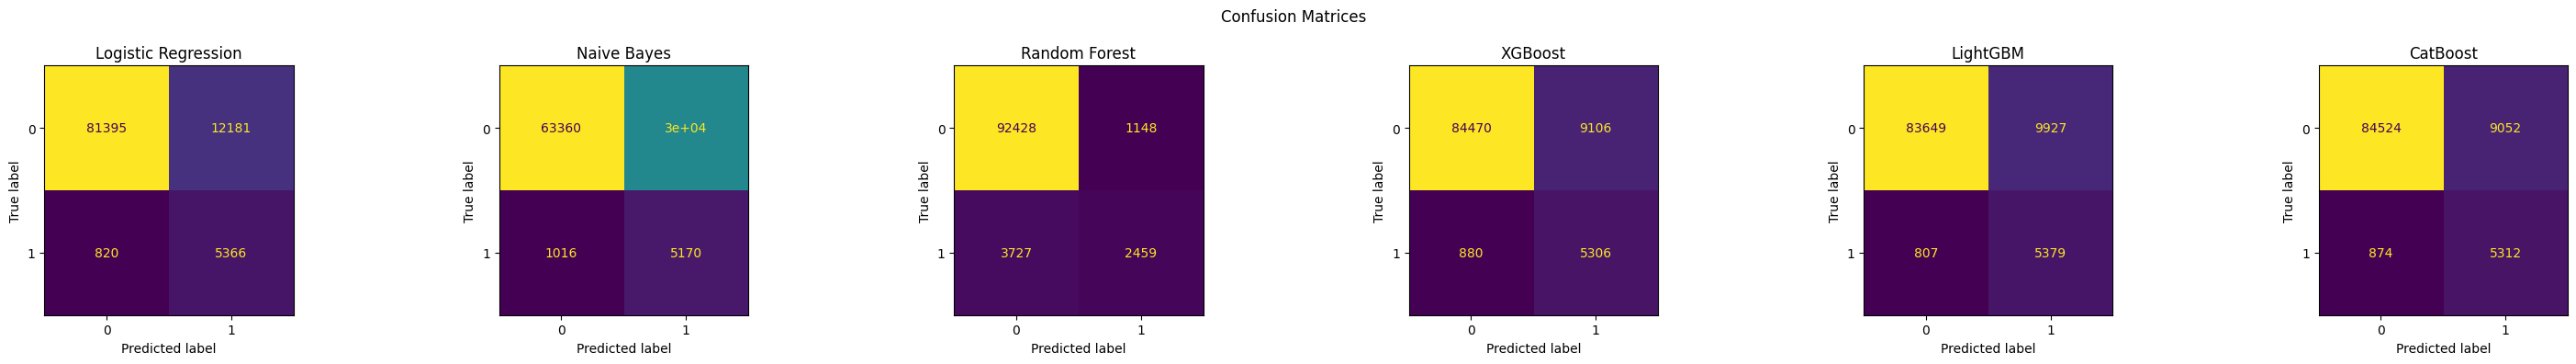

Saved confusion matrices to reports\baseline_confusion_matrices.png


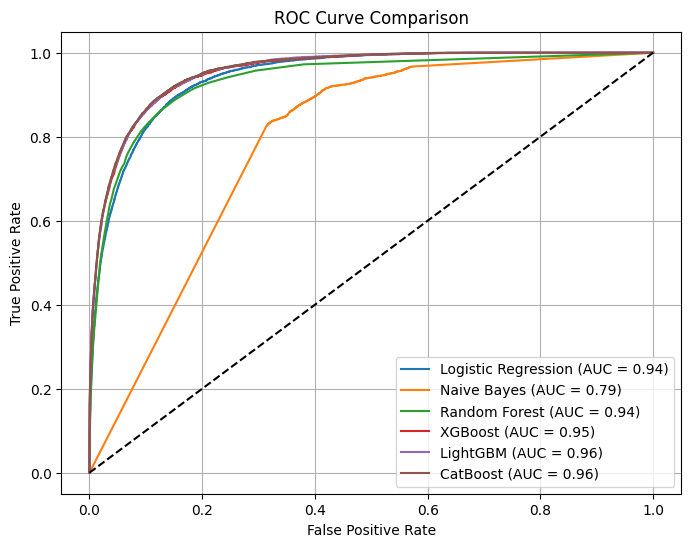

Saved ROC curve to reports\baseline_roc_curve_comparison.png


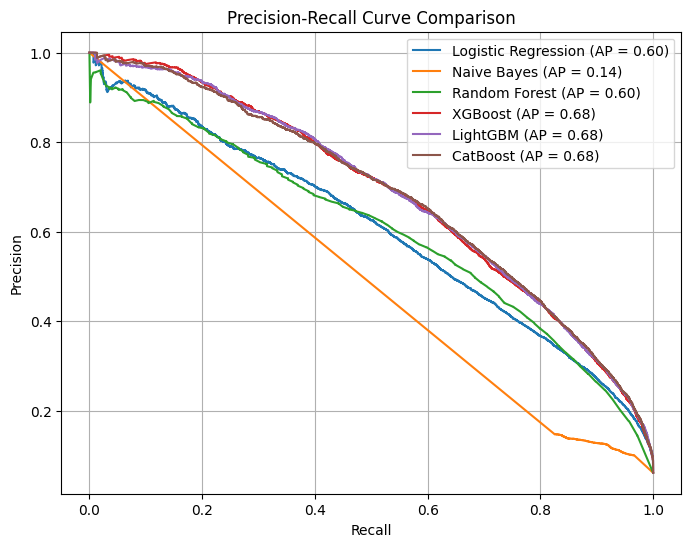

Saved precision-recall curve to reports\baseline_pr_curve_comparison.png


In [12]:
plot_model_evaluations_full(
    models, X_test_ohe, y_test,
    X_test_mixed=X_test, cat_features=cat_features,
    save_dir="reports"
)

---
#### Model Selection 

After comparing multiple baseline models using ROC AUC, Precision-Recall curves, and confusion matrices, it is clear that boosting-based methods (XGBoost, LightGBM, CatBoost) outperform traditional algorithms such as Logistic Regression, Naive Bayes, and Random Forest. Among the boosting models, CatBoost achieves top-tier performance metrics and offers additional practical advantages:

- Native handling of categorical features: CatBoost can directly ingest categorical variables without the need for manual encoding, simplifying the preprocessing pipeline.
- Robustness to missing values: it handles missing data natively, reducing the need for complex imputation strategies.

For these reasons, **CatBoost** was selected as the primary model for further tuning and deployment.

---

## 4. Fine-tuning Best model with Cross-Validation

We optimize CatBoost hyperparameters (iterations, learning_rate, depth, l2_leaf_reg) using stratified cross-validation and RandomizedSearchCV, targeting the best F1-score (or recall) on the minority class.

Best parameters are then used to retrain the model on the whole training set for evaluation on the test set.


In [7]:
use_gpu = get_gpu_device_count() > 0

cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
catboost_model = CatBoostClassifier(
    task_type="GPU" if use_gpu else "CPU",
    devices="0",
    auto_class_weights='Balanced',
    verbose=0,
    random_state=42
)

param_dist = {
    'iterations': [300, 500, 800, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='f1',  #'recall','roc_auc'
    cv=cv,
    verbose=2,
    n_jobs=1 if use_gpu else -1
)

random_search.fit(X_train, y_train, cat_features=cat_features)
print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  56.5s
[CV] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  57.9s
[CV] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  58.6s
[CV] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  59.4s
[CV] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time= 1.1min
[CV] END depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.1; total time=  48.8s
[CV] END depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.1; total time=  48.5s
[CV] END depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.1; total time=  47.3s
[CV] END depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.1; total time=  46.1s
[CV] END depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.1; total time=  46.0s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, lear

### Save and Analyze Cross-Validation Tuning Results

After hyperparameter tuning, we export all results for further analysis and reporting.


In [8]:
# Convert results to DataFrame
cv_results_df = pd.DataFrame(random_search.cv_results_)
columns_to_keep = [
    'params',
    'mean_test_score', 'std_test_score',
    'rank_test_score'
] + [col for col in cv_results_df.columns if col.startswith('split')]

cv_results_df = cv_results_df[columns_to_keep]

# Sort by best score
cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)

print("Full tuning results saved to catboost_randomsearch_cv_report.csv")
cv_results_df.head(10)  


Full tuning results saved to catboost_randomsearch_cv_report.csv


,params,mean_test_score,std_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,"{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iter...",0.561003,0.003950,1,0.563367,0.565435,0.559849,0.553967,0.562394
11,"{'learning_rate': 0.05, 'l2_leaf_reg': 7, 'ite...",0.551683,0.004303,2,0.553589,0.555649,0.545096,0.548194,0.555886
0,"{'learning_rate': 0.05, 'l2_leaf_reg': 1, 'ite...",0.536133,0.002616,3,0.536131,0.538553,0.535008,0.531862,0.539110
14,"{'learning_rate': 0.05, 'l2_leaf_reg': 9, 'ite...",0.534280,0.004859,4,0.539176,0.537671,0.528432,0.528297,0.537826
16,"{'learning_rate': 0.03, 'l2_leaf_reg': 9, 'ite...",0.533271,0.004717,5,0.537511,0.535761,0.527603,0.527526,0.537953
1,"{'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iter...",0.522064,0.003289,6,0.518591,0.526738,0.519954,0.519750,0.525286
17,"{'learning_rate': 0.05, 'l2_leaf_reg': 5, 'ite...",0.503768,0.003746,7,0.500586,0.505024,0.504423,0.499054,0.509752
12,"{'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iter...",0.503470,0.004228,8,0.501281,0.507032,0.502208,0.497484,0.509344
15,"{'learning_rate': 0.03, 'l2_leaf_reg': 9, 'ite...",0.500068,0.002529,9,0.496827,0.500582,0.502187,0.497499,0.503247
2,"{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iter...",0.497433,0.003225,10,0.497174,0.500464,0.497131,0.491747,0.500648


In [9]:
# Save tuning results
cv_results_df.to_csv("reports/catboost_randomsearch_cv_report.csv", index=False)